In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.base import clone
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

from utils import custom_score, load_data

In [63]:
X_train = load_data('x_train.txt')
y_train = load_data('y_train.txt')

X = X_train.to_numpy()
y = y_train[0].to_numpy()

In [62]:
def top_n_accuracy(y_true: np.ndarray, y_prob: np.ndarray, reference_size: int = 5000, top_k_reference: int = 1000):
    """
    Calculates top n accuracy, takes into account the proportions of the data.

    Args:
        y_true (np.array): True binary labels (0 or 1) indicating actual energy usage status
        y_prob (np.array): Predicted probabilities
        reference_size (int): Size of the full dataset the top-k selection is based on (default=5000)
        top_k_reference (int): Number of households to target in the full dataset (default=1000)

    Returns:
        float: top n accuracy score
    """
    n = len(y_true)
    top_k = int(top_k_reference * n / reference_size)
    top_idx = np.argsort(y_prob)[-top_k:]
    
    score = accuracy_score(y_true[top_idx], np.round(y_prob[top_idx]))
    return score

def test_features(X, y, base_model, selected):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    fold_scores = []
    accs_top = []
    accs = []

    for train_idx, val_idx in kf.split(X, y):
        X_cv, X_val = X[train_idx][:, selected], X[val_idx][:, selected]
        y_cv, y_val = y[train_idx], y[val_idx]

        model = clone(base_model)
        pipeline = Pipeline([
            ('scale', StandardScaler()),
            ('clf', model)
        ])
        pipeline.fit(X_cv, y_cv)
        y_val_prob = pipeline.predict_proba(X_val)[:, 1]

        score = custom_score(y_val, y_val_prob, num_features=len(selected))
        fold_scores.append(score)

        acc_top = top_n_accuracy(y_val, y_val_prob)
        accs_top.append(acc_top)

        acc = accuracy_score(y_val, np.round(y_val_prob))
        accs.append(acc)

    return {"custom_score": round(float(np.mean(fold_scores)), 3),
            "top_n_accuracy": round(float(np.mean(accs_top)), 3),
            "accuracy": round(float(np.mean(accs)), 3)}

In [64]:
def forward_feature_selection(X, y, base_model, max_features=20, cv_splits=5, verbose=True):
    n_features_total = X.shape[1]
    selected = []
    remaining = list(range(n_features_total))
    best_score = -np.inf

    kf = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=42)

    i = 1
    while len(selected) < max_features and remaining:
        scores = []
        for candidate in tqdm(remaining, total=len(remaining)):
            current_features = selected + [candidate]
            fold_scores = []

            for train_idx, val_idx in kf.split(X, y):
                X_cv, X_val = X[train_idx][:, current_features], X[val_idx][:, current_features]
                y_cv, y_val = y[train_idx], y[val_idx]

                model = clone(base_model)
                pipeline = Pipeline([
                    ('scale', StandardScaler()),
                    ('clf', model)
                ])
                pipeline.fit(X_cv, y_cv)
                y_val_prob = pipeline.predict_proba(X_val)[:, 1]

                score = custom_score(y_val, y_val_prob, num_features=len(current_features))
                fold_scores.append(score)

            avg_score = np.mean(fold_scores)
            scores.append((avg_score, candidate))

        scores.sort(reverse=True)
        top_score, top_feature = scores[0]

        if top_score > best_score:
            selected.append(top_feature)
            remaining.remove(top_feature)
            best_score = top_score
            if verbose:
                print(f"Iteration {i}: added feature {top_feature}, score improved to {top_score:.2f}")
        else:
            if verbose:
                print(f"Iteration {i}: no further improvement, stopping")
            break
        i += 1

    return selected, best_score

### Tests

In [79]:
base_model = LogisticRegression(random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:18<00:00, 26.40it/s]


Iteration 1: added feature 8, score improved to 7210.00


100%|██████████| 499/499 [00:23<00:00, 21.62it/s]

Iteration 2: no further improvement, stopping

Final selected features: [8]
Best CV score: 7210.00
{'custom_score': 7210.0, 'top_n_accuracy': 0.741, 'accuracy': 0.652}


In [80]:
base_model = GaussianNB()

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:16<00:00, 29.83it/s]


Iteration 1: added feature 8, score improved to 7210.00


100%|██████████| 499/499 [00:17<00:00, 28.92it/s]


Iteration 2: no further improvement, stopping

Final selected features: [8]
Best CV score: 7210.00
{'custom_score': 7210.0, 'top_n_accuracy': 0.741, 'accuracy': 0.653}


In [81]:
base_model = BernoulliNB()

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:18<00:00, 26.70it/s]


Iteration 1: added feature 2, score improved to 7130.00


100%|██████████| 499/499 [00:18<00:00, 26.90it/s]


Iteration 2: no further improvement, stopping

Final selected features: [2]
Best CV score: 7130.00
{'custom_score': 7130.0, 'top_n_accuracy': 0.733, 'accuracy': 0.707}


In [9]:
base_model = RandomForestClassifier(max_depth=5, random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [14:20<00:00,  1.72s/it]


Iteration 1: added feature 8, score improved to 7070.00


100%|██████████| 499/499 [14:20<00:00,  1.72s/it]


Iteration 2: added feature 139, score improved to 7090.00


100%|██████████| 498/498 [13:35<00:00,  1.64s/it]


Iteration 3: no further improvement, stopping

Final selected features: [8, 139]
Best CV score: 7090.00
{'custom_score': 7090.0, 'top_n_accuracy': 0.749, 'accuracy': 0.652}


In [30]:
base_model = GradientBoostingClassifier(random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [12:23<00:00,  1.49s/it]


Iteration 1: added feature 3, score improved to 7160.00


100%|██████████| 499/499 [48:36<00:00,  5.84s/it]   


Iteration 2: no further improvement, stopping

Final selected features: [3]
Best CV score: 7160.00
{'custom_score': 7160.0, 'top_n_accuracy': 0.736, 'accuracy': 0.662}


In [66]:
base_model = AdaBoostClassifier(random_state=10)

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [05:29<00:00,  1.52it/s]


Iteration 1: added feature 3, score improved to 7170.00


100%|██████████| 499/499 [06:35<00:00,  1.26it/s]


Iteration 2: no further improvement, stopping

Final selected features: [3]
Best CV score: 7170.00
{'custom_score': 7170.0, 'top_n_accuracy': 0.737, 'accuracy': 0.668}


In [85]:
base_model = KNeighborsClassifier()

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [00:44<00:00, 11.34it/s]


Iteration 1: added feature 2, score improved to 6740.00


100%|██████████| 499/499 [00:47<00:00, 10.53it/s]


Iteration 2: added feature 21, score improved to 6930.00


100%|██████████| 498/498 [00:43<00:00, 11.34it/s]


Iteration 3: no further improvement, stopping

Final selected features: [2, 21]
Best CV score: 6930.00
{'custom_score': 6930.0, 'top_n_accuracy': 0.733, 'accuracy': 0.662}


In [87]:
base_model = XGBClassifier()

selected_features, best_cv_score = forward_feature_selection(
    X, y,
    base_model=base_model,
)

print(f"\nFinal selected features: {selected_features}")
print(f"Best CV score: {best_cv_score:.2f}")

print(test_features(X, y, base_model, selected_features))

100%|██████████| 500/500 [05:14<00:00,  1.59it/s]


Iteration 1: added feature 3, score improved to 7200.00


100%|██████████| 499/499 [04:59<00:00,  1.67it/s]


Iteration 2: no further improvement, stopping

Final selected features: [3]
Best CV score: 7200.00
{'custom_score': 7200.0, 'top_n_accuracy': 0.74, 'accuracy': 0.657}


In [ ]:
"""
sets of features obtained from running the algorithm are:
- 2
- 3
- 8
- 8, 139
feature 2 was already tested using grid search in another notebook, thus we omit it here 
"""

### Grid search

In [82]:
from grid_search import *

In [73]:
X_test = load_data('x_test.txt')
X_test = X_test.to_numpy()

#### features = [8]

Testing: Logistic Regression


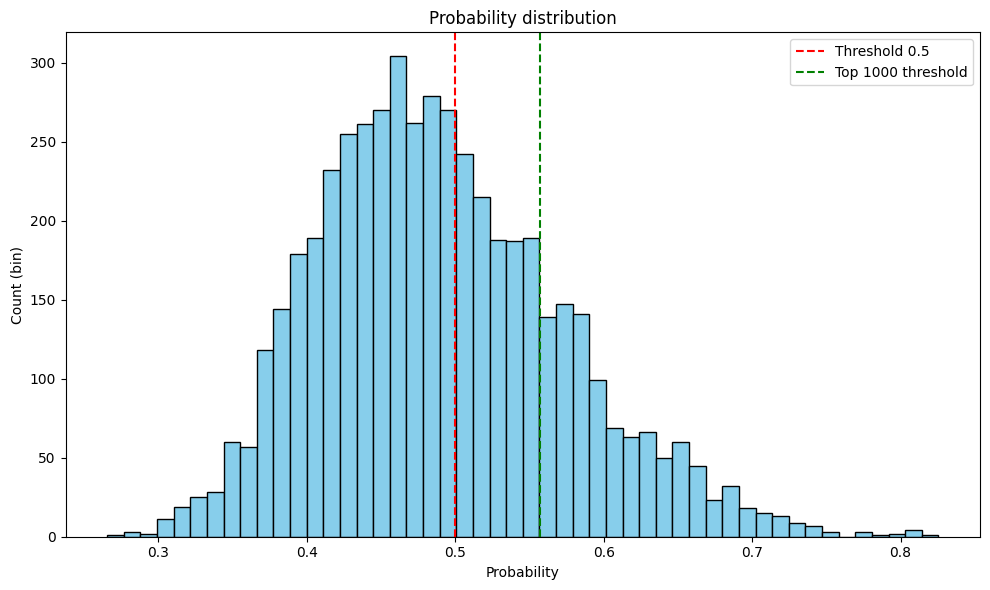

Logistic Regression: 7210.0000
   Parameters: {'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

   Metrics: {'score': np.float64(7190.0), 'acc_top': np.float64(0.739), 'acc_global': np.float64(0.6514), 'logloss_top': 0.6195808699422336, 'logloss_global': 0.6571292893811422}

Testing: Random Forest


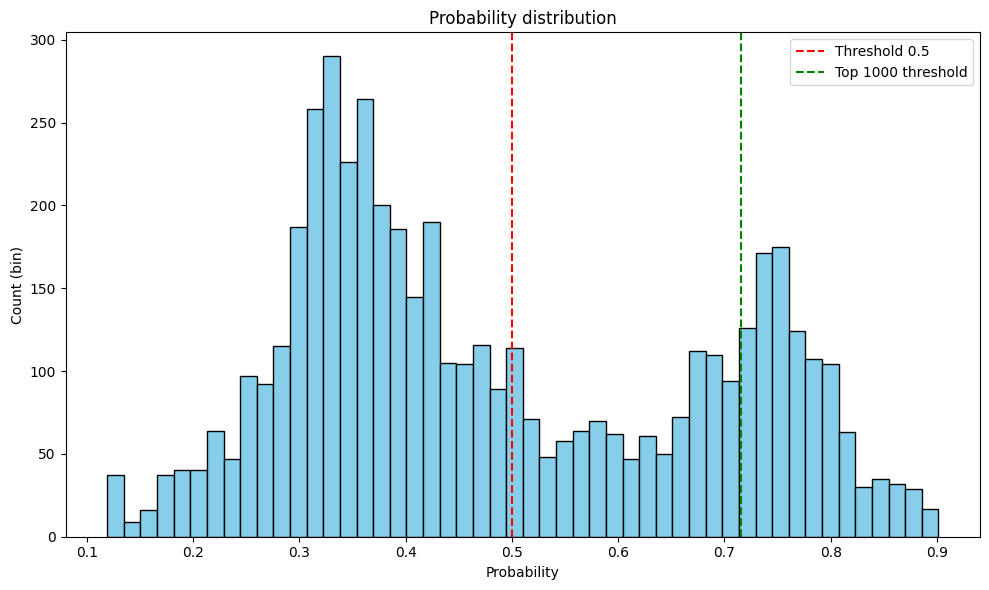

Random Forest: 7090.0000
   Parameters: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}

   Metrics: {'score': np.float64(6950.0), 'acc_top': np.float64(0.715), 'acc_global': np.float64(0.6478), 'logloss_top': 0.6238480526232705, 'logloss_global': 0.6551974333216004}

Testing: Gradient Boosting


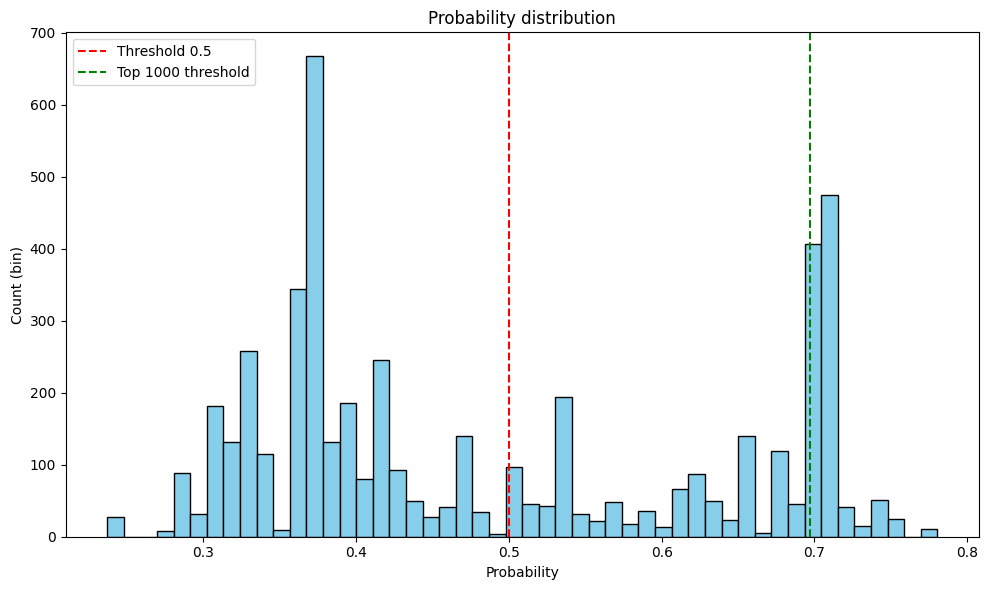

Gradient Boosting: 7220.0000
   Parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 1.0}

   Metrics: {'score': np.float64(7070.0), 'acc_top': np.float64(0.727), 'acc_global': np.float64(0.6468), 'logloss_top': 0.5905792392393377, 'logloss_global': 0.6413020457595396}

Testing: XGBoost


/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:54:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:54:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:54:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:54:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


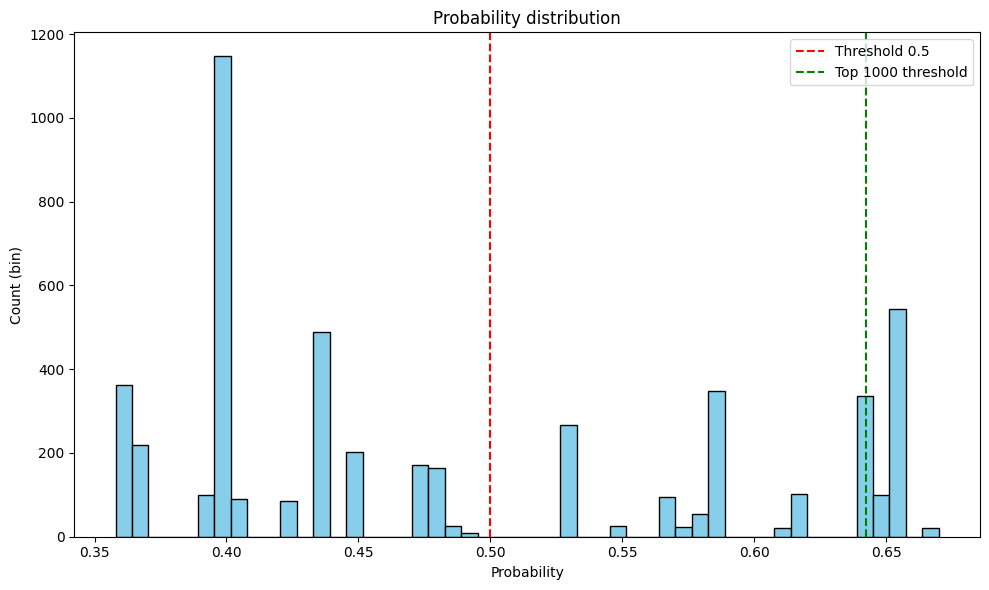

XGBoost: 7170.0000
   Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 100, 'clf__subsample': 1.0}

   Metrics: {'score': np.float64(7080.0), 'acc_top': np.float64(0.728), 'acc_global': np.float64(0.6524), 'logloss_top': 0.6008324052020784, 'logloss_global': 0.6453961270989043}

Testing: SVC


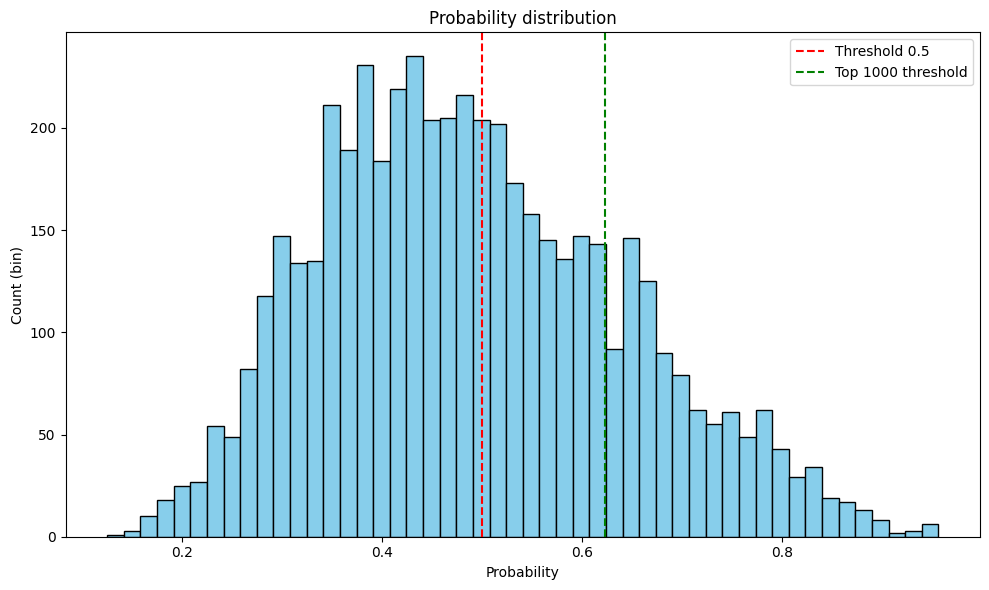

SVC: 7210.0000
   Parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

   Metrics: {'score': np.float64(7190.0), 'acc_top': np.float64(0.739), 'acc_global': np.float64(0.6504), 'logloss_top': 0.5919984702101166, 'logloss_global': 0.6433171359718953}

Testing: KNN


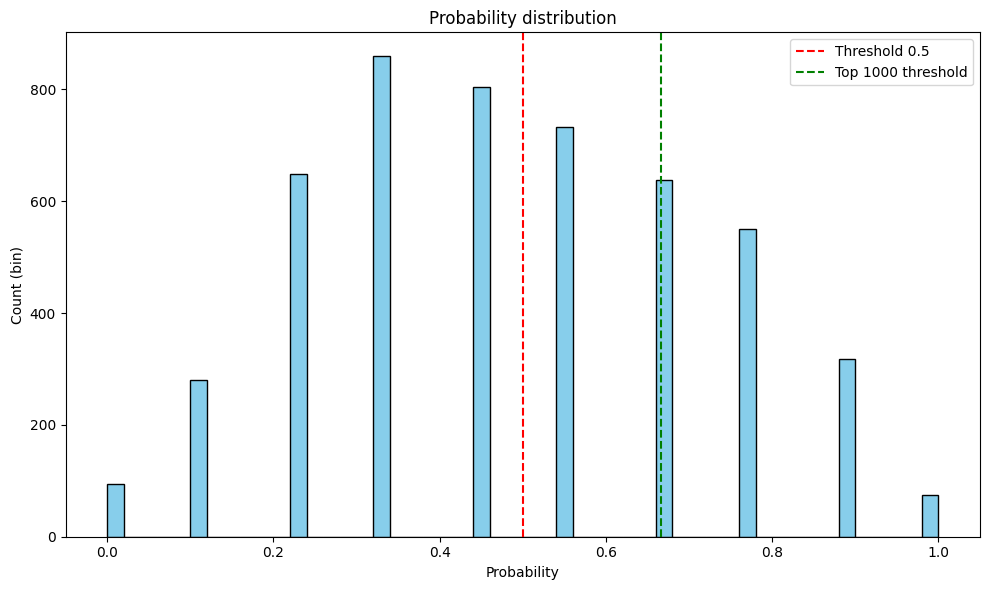

KNN: 6770.0000
   Parameters: {'clf__metric': 'euclidean', 'clf__n_neighbors': 9, 'clf__weights': 'uniform'}

   Metrics: {'score': np.float64(6760.0), 'acc_top': np.float64(0.696), 'acc_global': np.float64(0.6234), 'logloss_top': 1.6404589289703728, 'logloss_global': 1.059252387750495}

Testing: Naive Bayes


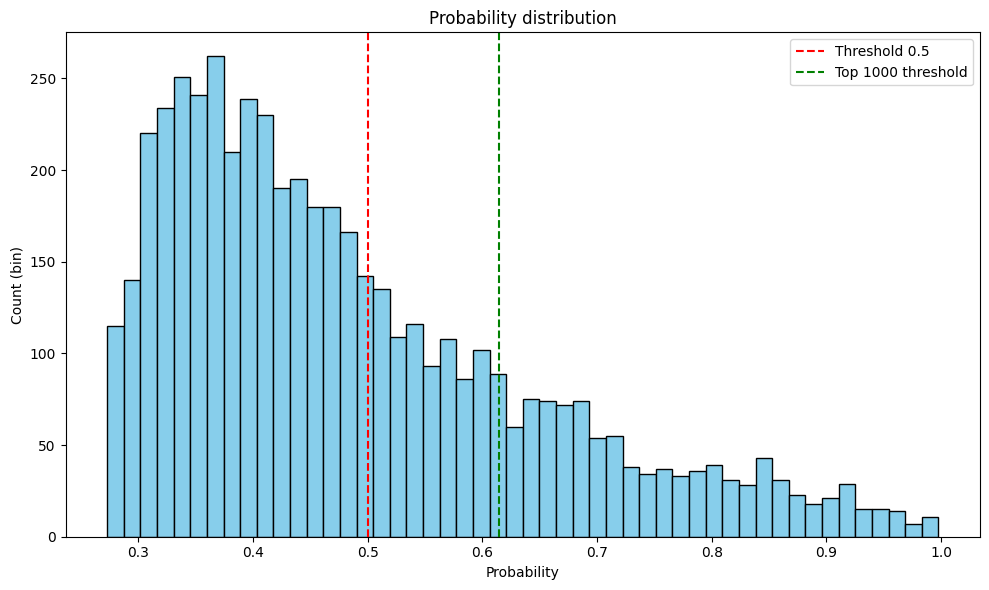

Naive Bayes: 7210.0000
   Parameters: {}

   Metrics: {'score': np.float64(7190.0), 'acc_top': np.float64(0.739), 'acc_global': np.float64(0.6528), 'logloss_top': 0.6223616364968441, 'logloss_global': 0.6486060692997931}

Testing: AdaBoost


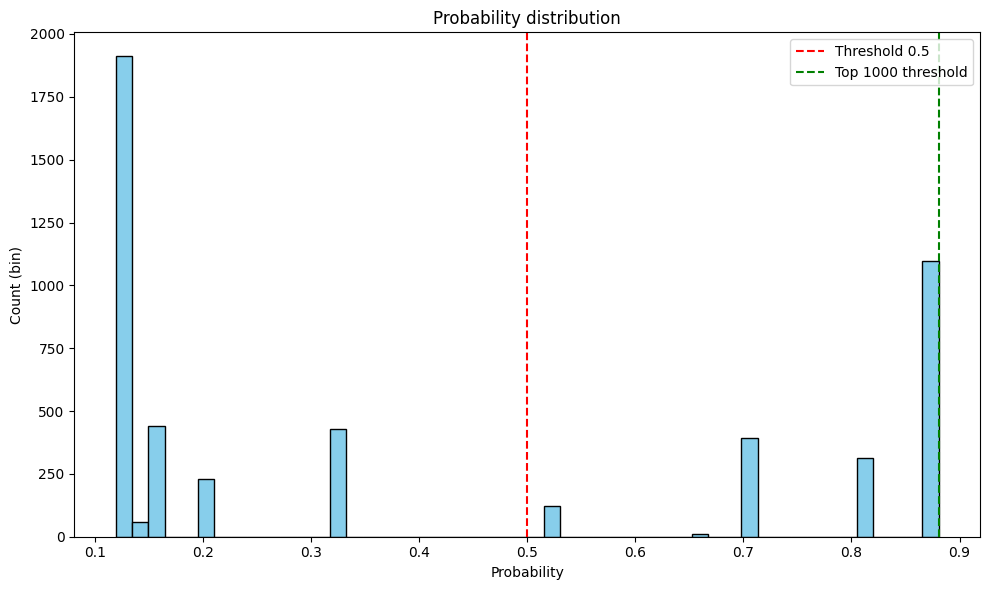

AdaBoost: 7150.0000
   Parameters: {'clf__learning_rate': 0.01, 'clf__n_estimators': 200}

   Metrics: {'score': np.float64(7200.0), 'acc_top': np.float64(0.74), 'acc_global': np.float64(0.6514), 'logloss_top': 0.6469280110429724, 'logloss_global': 0.7447770474713862}



In [75]:
selected = [8]

X_k = X[:, selected]
X_test_k = X_test[:, selected]


results = []
for name, (model, param_grid) in models_params.items():
    print(f"Testing: {name}")
    best_model, best_score, best_params, metrics = evaluate_model_with_gridsearch(
        model, param_grid, X_k, y, X_test_k, n_splits=5, num_features=len(selected), top_k=1000
    )
    results.append((name, best_score, best_params, metrics))
    print(f"{name}: {best_score:.4f}")
    print(f"   Parameters: {best_params}\n")
    print(f"   Metrics: {metrics}\n")

#### features = [3]

Testing: Logistic Regression


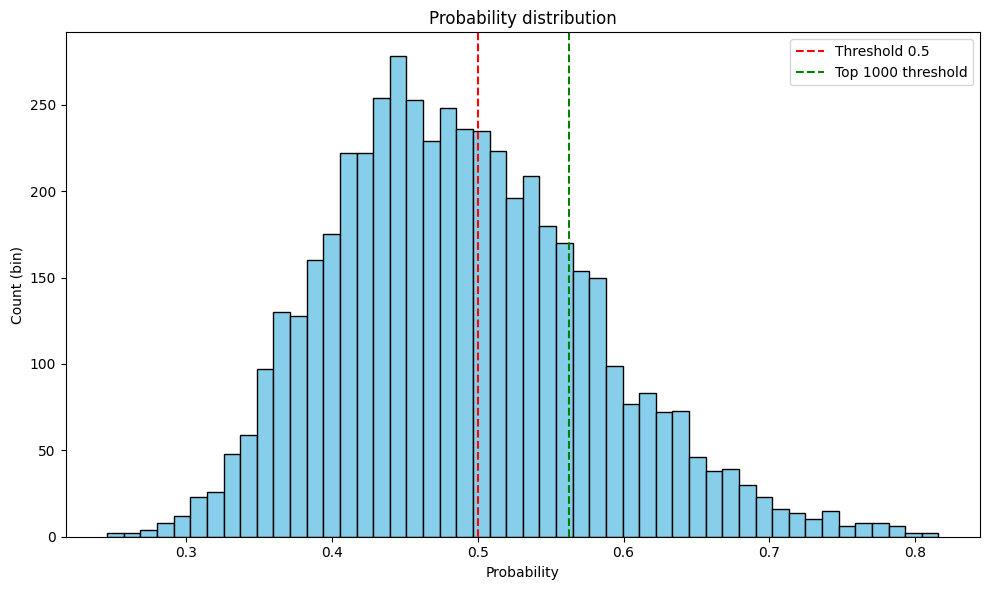

Logistic Regression: 7190.0000
   Parameters: {'clf__C': 0.001, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

   Metrics: {'score': np.float64(7200.0), 'acc_top': np.float64(0.74), 'acc_global': np.float64(0.6648), 'logloss_top': 0.6156590176119188, 'logloss_global': 0.6490149742672935}

Testing: Random Forest


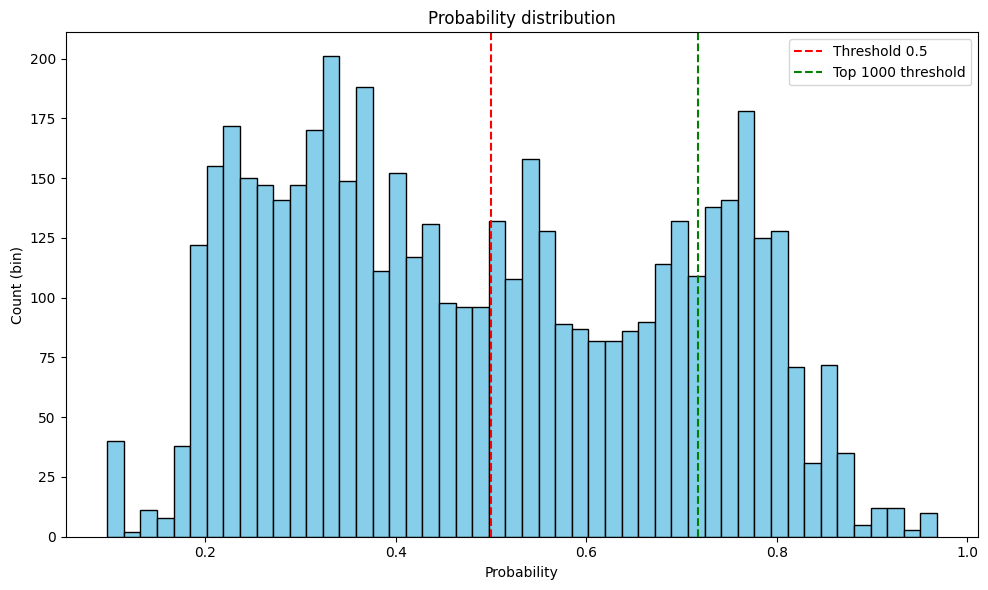

Random Forest: 7250.0000
   Parameters: {'clf__max_depth': 10, 'clf__max_features': 'sqrt', 'clf__min_samples_leaf': 2, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

   Metrics: {'score': np.float64(7210.0), 'acc_top': np.float64(0.741), 'acc_global': np.float64(0.6482), 'logloss_top': 0.5875658988439926, 'logloss_global': 0.6429118051428789}

Testing: Gradient Boosting


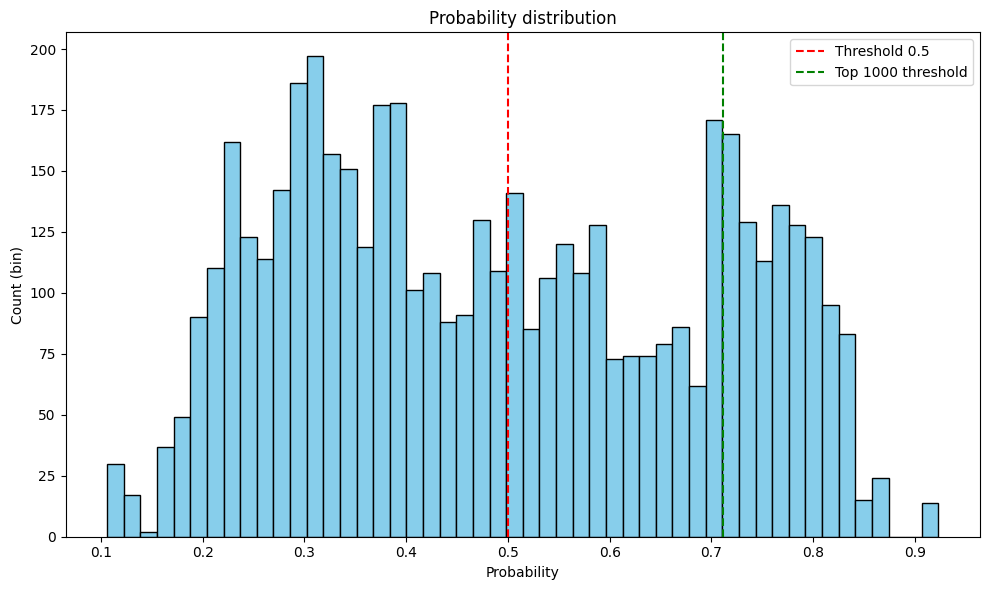

Gradient Boosting: 7240.0000
   Parameters: {'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 0.8}

   Metrics: {'score': np.float64(7230.0), 'acc_top': np.float64(0.743), 'acc_global': np.float64(0.6532), 'logloss_top': 0.579172723903376, 'logloss_global': 0.6371252507042465}

Testing: XGBoost


/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [20:59:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


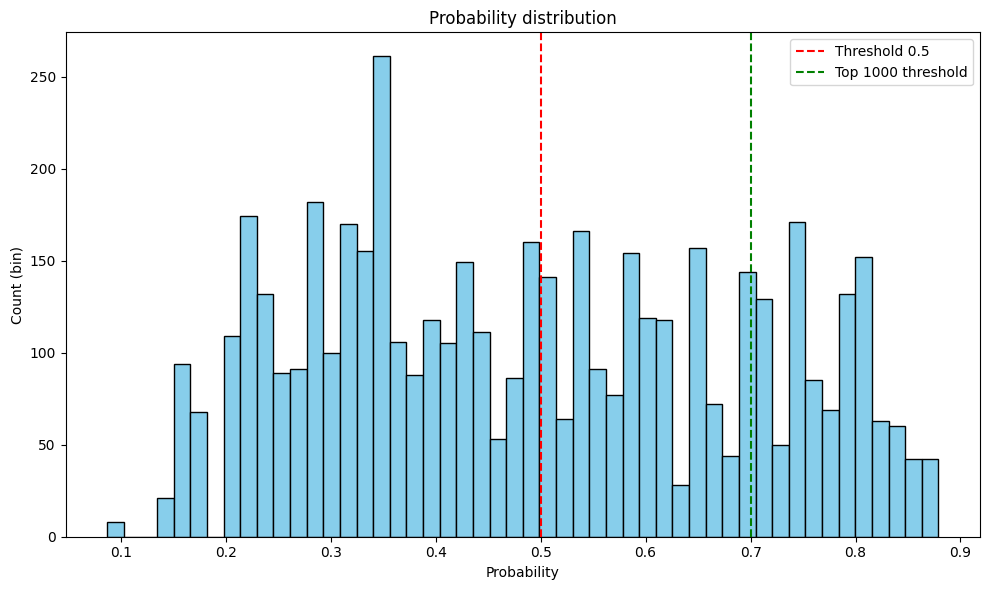

XGBoost: 7300.0000
   Parameters: {'clf__colsample_bytree': 0.8, 'clf__learning_rate': 0.05, 'clf__max_depth': 5, 'clf__n_estimators': 200, 'clf__subsample': 0.8}

   Metrics: {'score': np.float64(7310.0), 'acc_top': np.float64(0.751), 'acc_global': np.float64(0.6602), 'logloss_top': 0.5685081921430818, 'logloss_global': 0.6336963939140066}

Testing: SVC


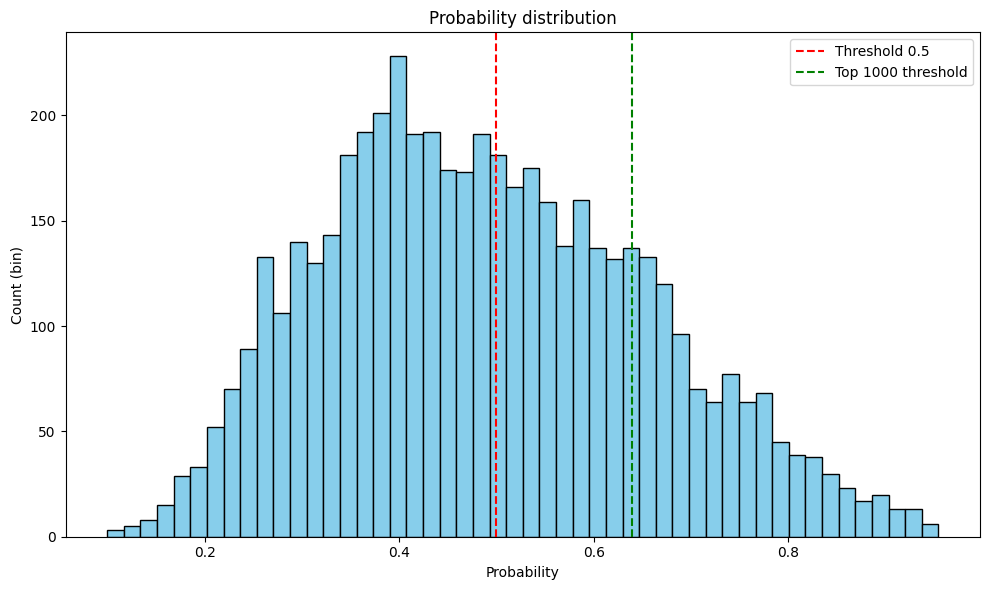

SVC: 7190.0000
   Parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

   Metrics: {'score': np.float64(7190.0), 'acc_top': np.float64(0.739), 'acc_global': np.float64(0.6662), 'logloss_top': 0.5990791130030503, 'logloss_global': 0.6314637149598317}

Testing: KNN


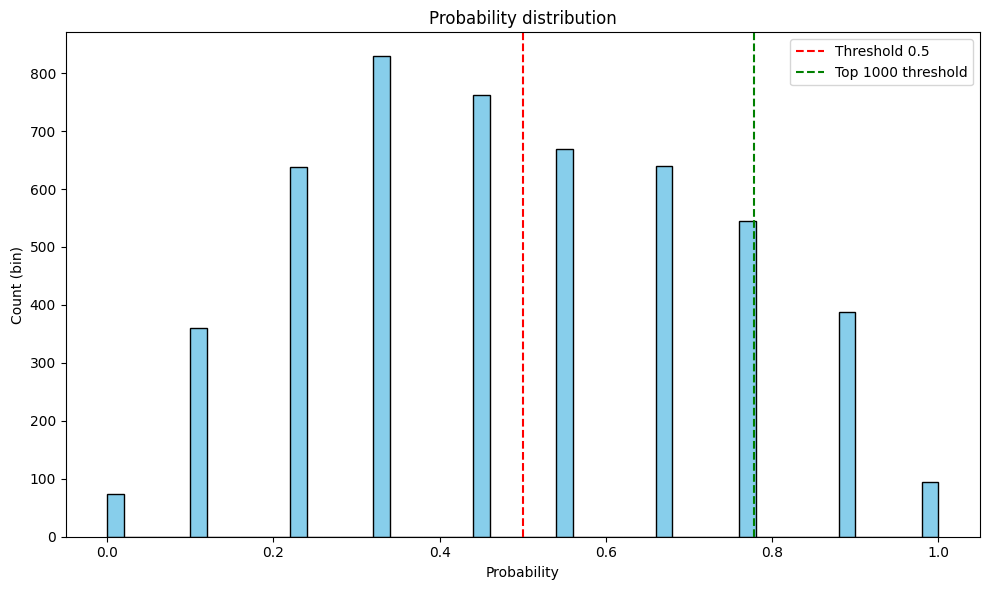

KNN: 6870.0000
   Parameters: {'clf__metric': 'euclidean', 'clf__n_neighbors': 9, 'clf__weights': 'uniform'}

   Metrics: {'score': np.float64(6870.0), 'acc_top': np.float64(0.707), 'acc_global': np.float64(0.6374), 'logloss_top': 1.5995751106924563, 'logloss_global': 1.0813116824081337}

Testing: Naive Bayes


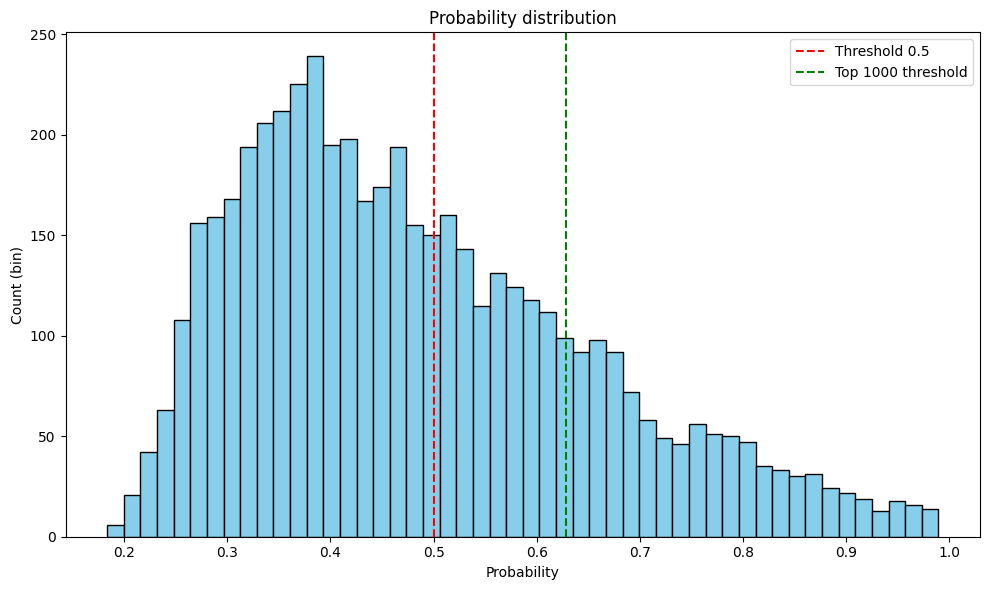

Naive Bayes: 7190.0000
   Parameters: {}

   Metrics: {'score': np.float64(7200.0), 'acc_top': np.float64(0.74), 'acc_global': np.float64(0.6616), 'logloss_top': 0.6220622489557809, 'logloss_global': 0.6364765598392769}

Testing: AdaBoost


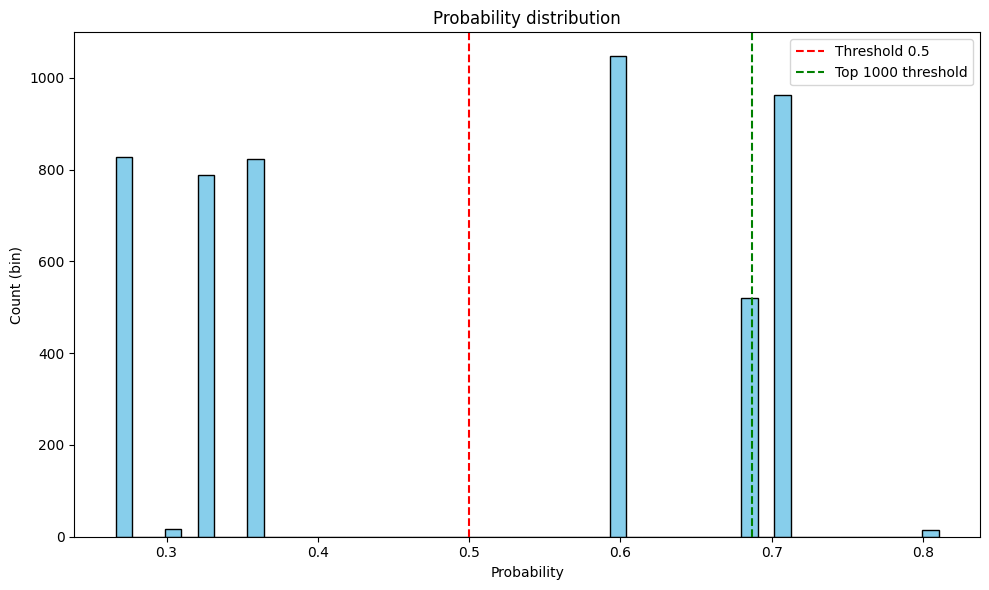

AdaBoost: 7180.0000
   Parameters: {'clf__learning_rate': 1.0, 'clf__n_estimators': 100}

   Metrics: {'score': np.float64(7130.0), 'acc_top': np.float64(0.733), 'acc_global': np.float64(0.6682), 'logloss_top': 0.5806107177796186, 'logloss_global': 0.6261828514837947}



In [76]:
selected = [3]

X_k = X[:, selected]
X_test_k = X_test[:, selected]


results = []
for name, (model, param_grid) in models_params.items():
    print(f"Testing: {name}")
    best_model, best_score, best_params, metrics = evaluate_model_with_gridsearch(
        model, param_grid, X_k, y, X_test_k, n_splits=5, num_features=len(selected), top_k=1000
    )
    results.append((name, best_score, best_params, metrics))
    print(f"{name}: {best_score:.4f}")
    print(f"   Parameters: {best_params}\n")
    print(f"   Metrics: {metrics}\n")

#### features = [8, 139]

Testing: Logistic Regression


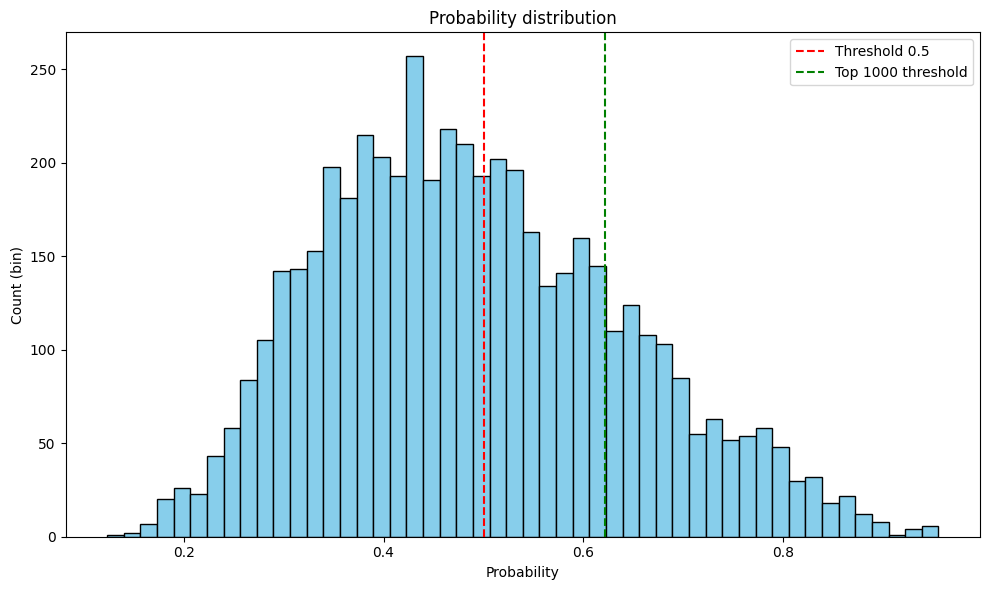

Logistic Regression: 7060.0000
   Parameters: {'clf__C': 0.1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}

   Metrics: {'score': np.float64(7040.0), 'acc_top': np.float64(0.744), 'acc_global': np.float64(0.6504), 'logloss_top': 0.5886193492286433, 'logloss_global': 0.6432993709584414}

Testing: Random Forest


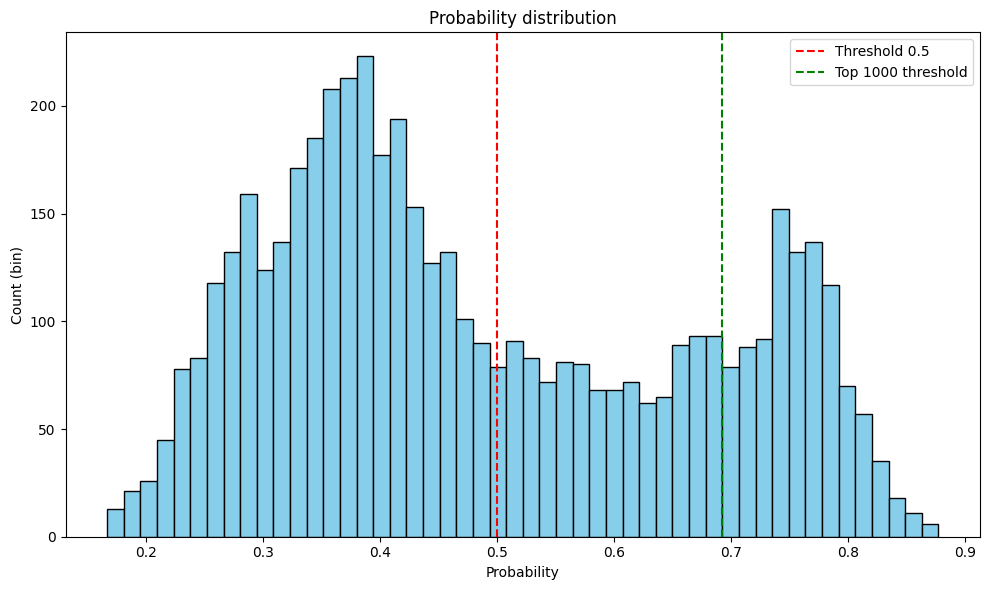

Random Forest: 6990.0000
   Parameters: {'clf__max_depth': 10, 'clf__max_features': 'log2', 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 10, 'clf__n_estimators': 200}

   Metrics: {'score': np.float64(6900.0), 'acc_top': np.float64(0.73), 'acc_global': np.float64(0.641), 'logloss_top': 0.5955908204345353, 'logloss_global': 0.6475641562317971}

Testing: Gradient Boosting


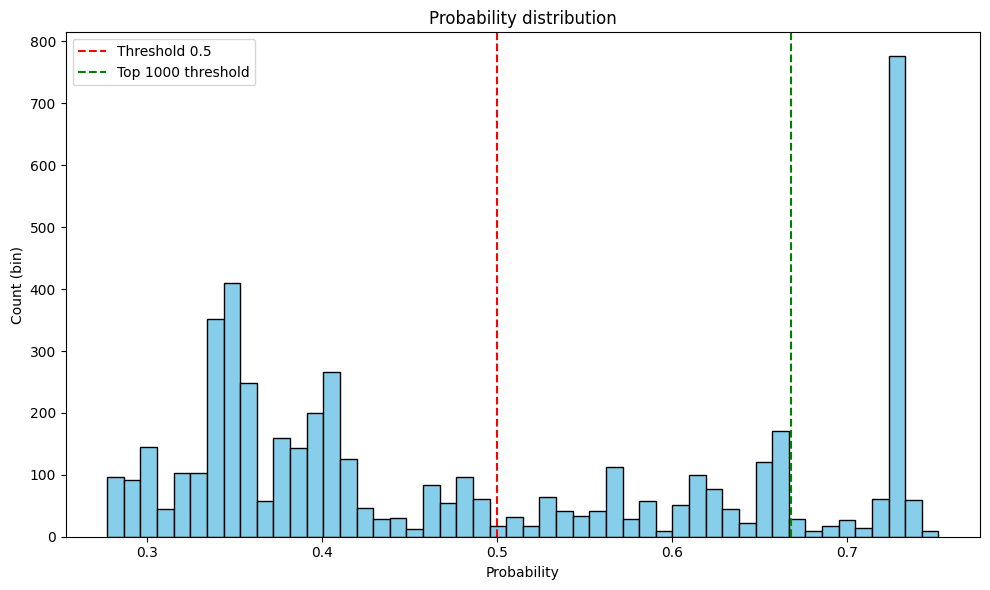

Gradient Boosting: 7130.0000
   Parameters: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 300, 'clf__subsample': 1.0}

   Metrics: {'score': np.float64(7130.0), 'acc_top': np.float64(0.753), 'acc_global': np.float64(0.6522), 'logloss_top': 0.5643419119565422, 'logloss_global': 0.6386431997037568}

Testing: XGBoost


/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/tymek/mini/AML-projects/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:09:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


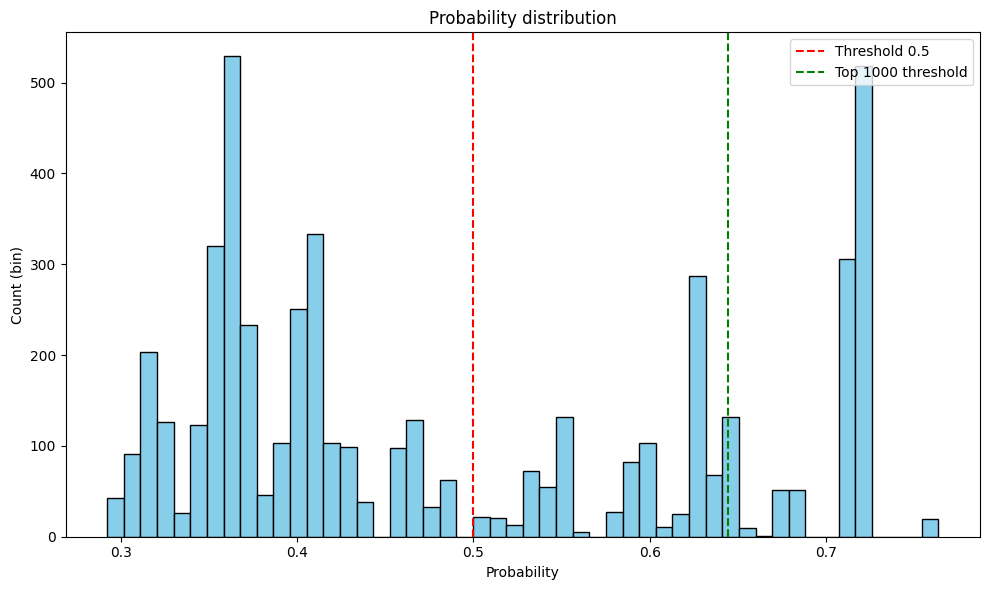

XGBoost: 7060.0000
   Parameters: {'clf__colsample_bytree': 1.0, 'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 200, 'clf__subsample': 1.0}

   Metrics: {'score': np.float64(7000.0), 'acc_top': np.float64(0.74), 'acc_global': np.float64(0.6494), 'logloss_top': 0.5756627959738657, 'logloss_global': 0.6394826101798625}

Testing: SVC


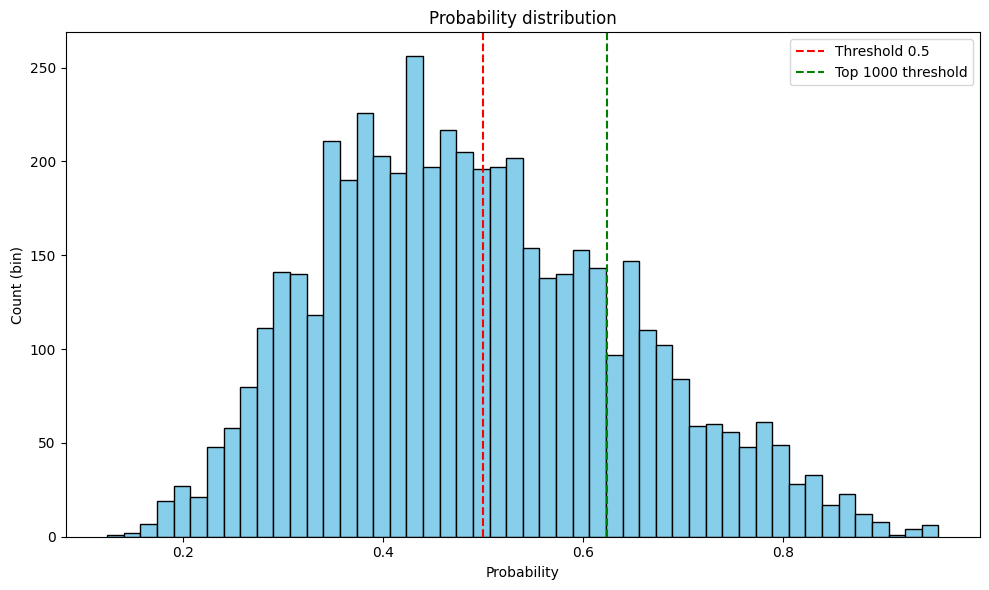

SVC: 7060.0000
   Parameters: {'clf__C': 1, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}

   Metrics: {'score': np.float64(7030.0), 'acc_top': np.float64(0.743), 'acc_global': np.float64(0.6496), 'logloss_top': 0.5891023039077975, 'logloss_global': 0.6433325338553965}

Testing: KNN


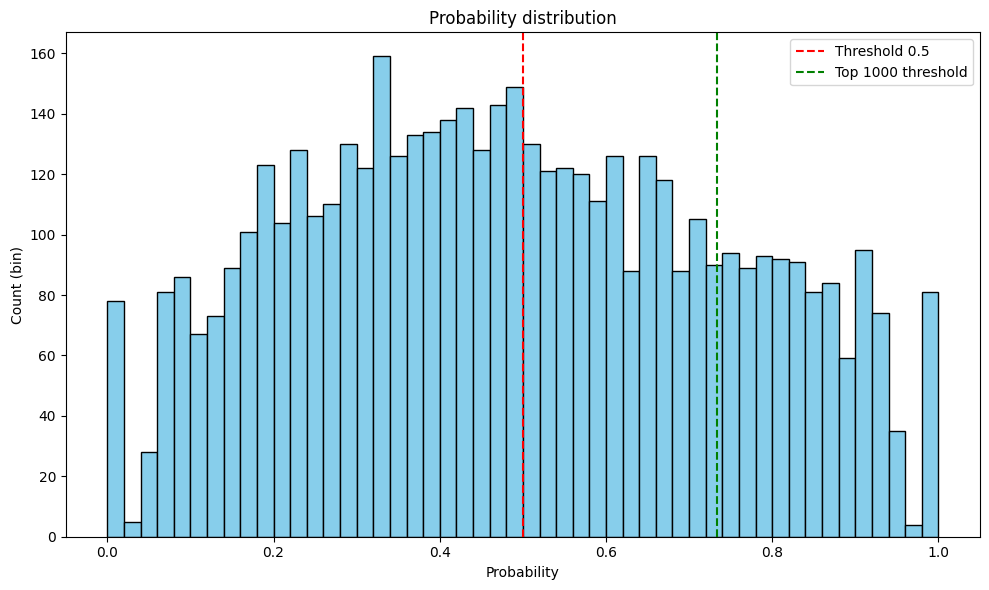

KNN: 6370.0000
   Parameters: {'clf__metric': 'manhattan', 'clf__n_neighbors': 9, 'clf__weights': 'distance'}

   Metrics: {'score': np.float64(6350.0), 'acc_top': np.float64(0.675), 'acc_global': np.float64(0.6012), 'logloss_top': 1.5182105497788478, 'logloss_global': 0.991356256012744}

Testing: Naive Bayes


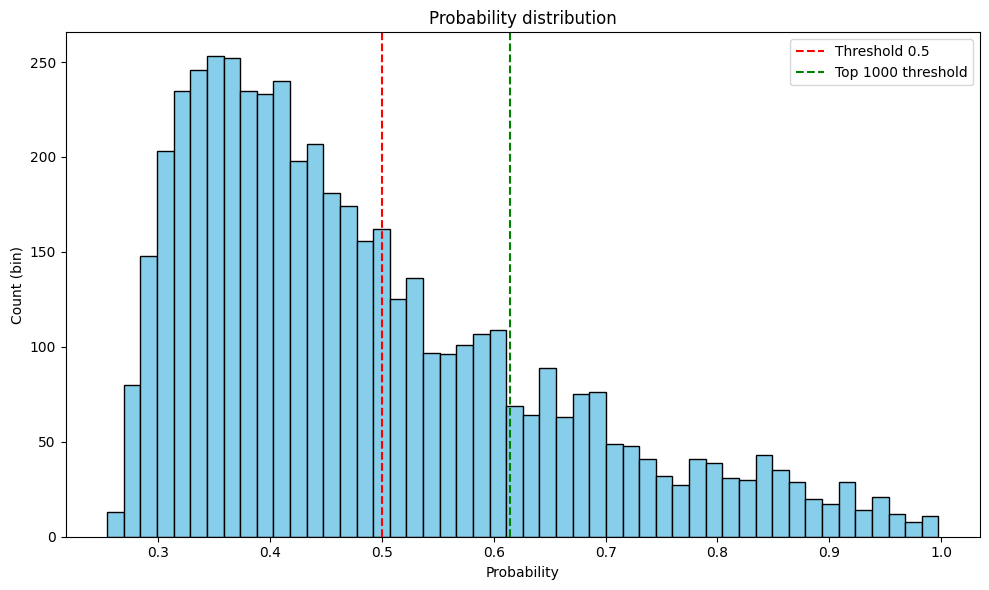

Naive Bayes: 7020.0000
   Parameters: {}

   Metrics: {'score': np.float64(7020.0), 'acc_top': np.float64(0.742), 'acc_global': np.float64(0.654), 'logloss_top': 0.6204065669255234, 'logloss_global': 0.6489110757705746}

Testing: AdaBoost


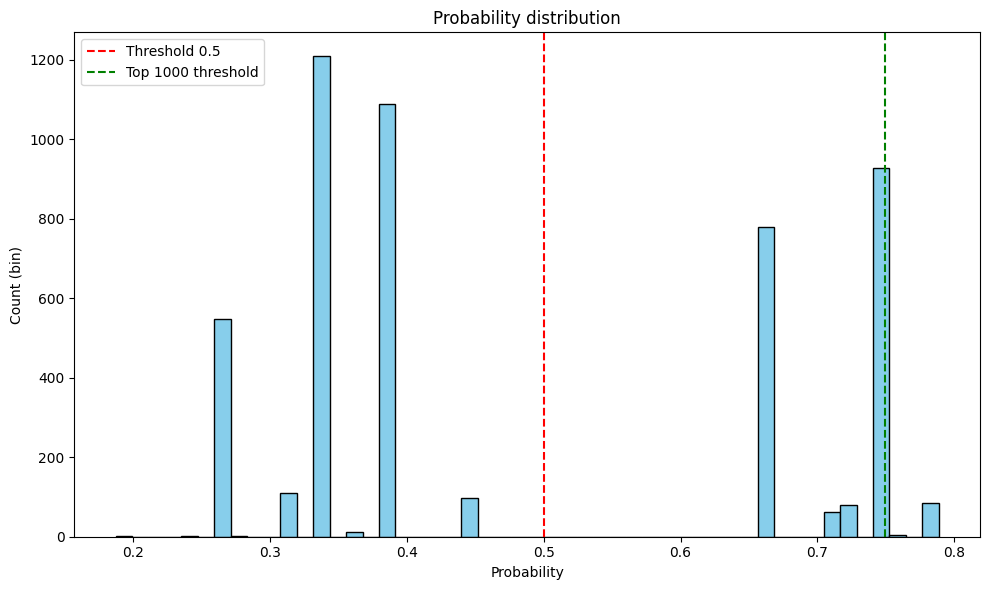

AdaBoost: 6990.0000
   Parameters: {'clf__learning_rate': 1.0, 'clf__n_estimators': 100}

   Metrics: {'score': np.float64(6870.0), 'acc_top': np.float64(0.727), 'acc_global': np.float64(0.6524), 'logloss_top': 0.5860541733290294, 'logloss_global': 0.641729339333147}



In [81]:
selected = [8, 139]

X_k = X[:, selected]
X_test_k = X_test[:, selected]


results = []
for name, (model, param_grid) in models_params.items():
    print(f"Testing: {name}")
    best_model, best_score, best_params, metrics = evaluate_model_with_gridsearch(
        model, param_grid, X_k, y, X_test_k, n_splits=5, num_features=len(selected), top_k=1000
    )
    results.append((name, best_score, best_params, metrics))
    print(f"{name}: {best_score:.4f}")
    print(f"   Parameters: {best_params}\n")
    print(f"   Metrics: {metrics}\n")